# Predicting the Popularity of Online News

# Table of contents

1. [Introduction](#introduction)
    1. [Downloading the needed libraries](#subparagraph1)
    1. [Downloading the data](#subparagraph2)
    1. [Data in histograms](#subparagraph3)
2. [Fixing outliers](#fixingoutliers)    
    1. [Spotting and removing outliers](#subparagraph4)
    1. [Creating a new data set without outliers](#subparagraph5)
2. [Correlations in data - numerically and graphically](#correlations)  
    1. [Correlation matrix](#subparagraph6)
    1. [Scatter matrices - 15 most correlated features](#subparagraph7)
2. [Need for Stratified Sampling?](#stratsamp)   
2. [Train Test split](#traintest)  
2. [Linear Regression](#linreg)  
    1. [Linear Regression -  RMSE and MAE for the Training set](#subparagraph8)
2. [Decision Tree](#dt)  
    1. [Decision Tree - RMSE and MAE for the Training Se](#subparagraph9)   
    1. [Cross Validation - Decision Tree](#subparagraph10)   
    1. [Cross Validation - Linear Regression](#subparagraph11) 
2. [Random Forest](#rf)     
    1. [Random Forest - RMSE and MAE for the Training Set](#subparagraph12) 
2. [Fine-tuning the Random Forest model](#finetuning)     
    1. [Cross Validation - Random Forest](#subparagraph13)     
2. [Summarizing RMSE and MAE for the three models - pre-Cross Validation](#summarize)    
2. [Hyperparameters and Feature Importance](#hyper) 
    1. [Finding the optimal number of hyperparameters through Grid Search](#subparagraph14)    
    1. [Finding the optimal number of hyperparameters through Randomized Search](#subparagraph15)  
    1. [Feature Importances - numerically and graphically](#subparagraph16)
2. [Evaluating the Final Model with the Test Set](#evaluate)  
2. [Conlusions](#conclusions) 

## 1. Introduction<a name="introduction"></a>
The source for the data can be found here https://archive.ics.uci.edu/ml/machine-learning-databases/00332. It consists of 39644 rows. The data comes from website https://mashable.com/ from beginning of 2015.Observations are online news articles with 60 features and the goal is to predict the level of popularity of the article, i.e. how many times it will be shared online by the reader. In other words, can we find a model which can predict the number of online 'shares' an article will get based on a set of variables attached to it.<br><BR>

In [1]:
%%HTML
<iframe width="640" height="360" src="https://mashable.com/" frameborder="0" gesture="media" allowfullscreen></iframe>

The methods used in this analysis are Linear Regression, Decision Tree and Random Forest. <br><BR>
The results of the original analysis are found in this paper: <br>
*K. Fernandes, P. Vinagre and P. Cortez. A Proactive Intelligent Decision Support System for Predicting the Popularity of Online News. Proceedings of the 17th EPIA 2015 - Portuguese Conference on Artificial Intelligence, September, Coimbra, Portugal.*


### Downloading the needed libraries<a name="subparagraph1"></a>
Obviously this part was finalized only after the completion of the whole analysis.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from pandas.tools.plotting import scatter_matrix

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import randint

import seaborn as sns

### Downloading the data <a name="subparagraph2"></a>

In [3]:
input_file =  "C:/Users/jangn/OneDrive/CODE/Datasets/OnlineNewsPopularity/OnlineNewsPopularity.csv"
df = pd.read_csv(input_file, header = 0)

df.head(5)

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


Checking the shape of the dataframe; number of rows and columns.

In [4]:
df.shape

(39644, 61)

Checking the types of data.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 61 columns):
url                              39644 non-null object
timedelta                        39644 non-null float64
n_tokens_title                   39644 non-null float64
n_tokens_content                 39644 non-null float64
n_unique_tokens                  39644 non-null float64
n_non_stop_words                 39644 non-null float64
n_non_stop_unique_tokens         39644 non-null float64
num_hrefs                        39644 non-null float64
num_self_hrefs                   39644 non-null float64
num_imgs                         39644 non-null float64
num_videos                       39644 non-null float64
average_token_length             39644 non-null float64
num_keywords                     39644 non-null float64
data_channel_is_lifestyle        39644 non-null float64
data_channel_is_entertainment    39644 non-null float64
data_channel_is_bus              39644 non-null floa

A statistical summary of the numerical attributes.

In [6]:
df.describe() 

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
count,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,...,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000
mean,354.530471,10.398749,546.514731,0.548216,0.996469,0.689175,10.883690,3.293638,4.544143,1.249874,...,0.095446,0.756728,-0.259524,-0.521944,-0.107500,0.282353,0.071425,0.341843,0.156064,3395.380184
std,214.163767,2.114037,471.107508,3.520708,5.231231,3.264816,11.332017,3.855141,8.309434,4.107855,...,0.071315,0.247786,0.127726,0.290290,0.095373,0.324247,0.265450,0.188791,0.226294,11626.950749
min,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,1.000000
25%,164.000000,9.000000,246.000000,0.470870,1.000000,0.625739,4.000000,1.000000,1.000000,0.000000,...,0.050000,0.600000,-0.328383,-0.700000,-0.125000,0.000000,0.000000,0.166667,0.000000,946.000000
50%,339.000000,10.000000,409.000000,0.539226,1.000000,0.690476,8.000000,3.000000,1.000000,0.000000,...,0.100000,0.800000,-0.253333,-0.500000,-0.100000,0.150000,0.000000,0.500000,0.000000,1400.000000
75%,542.000000,12.000000,716.000000,0.608696,1.000000,0.754630,14.000000,4.000000,4.000000,1.000000,...,0.100000,1.000000,-0.186905,-0.300000,-0.050000,0.500000,0.150000,0.500000,0.250000,2800.000000
max,731.000000,23.000000,8474.000000,701.000000,1042.000000,650.000000,304.000000,116.000000,128.000000,91.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.500000,1.000000,843300.000000


### Data in Histograms<a name="subparagraph3"></a>
Let's take a look at the data in histograms.There was quite a lot of categorical variables in the data, represented here by the high bars in many of the charts. 

<function matplotlib.pyplot.show>

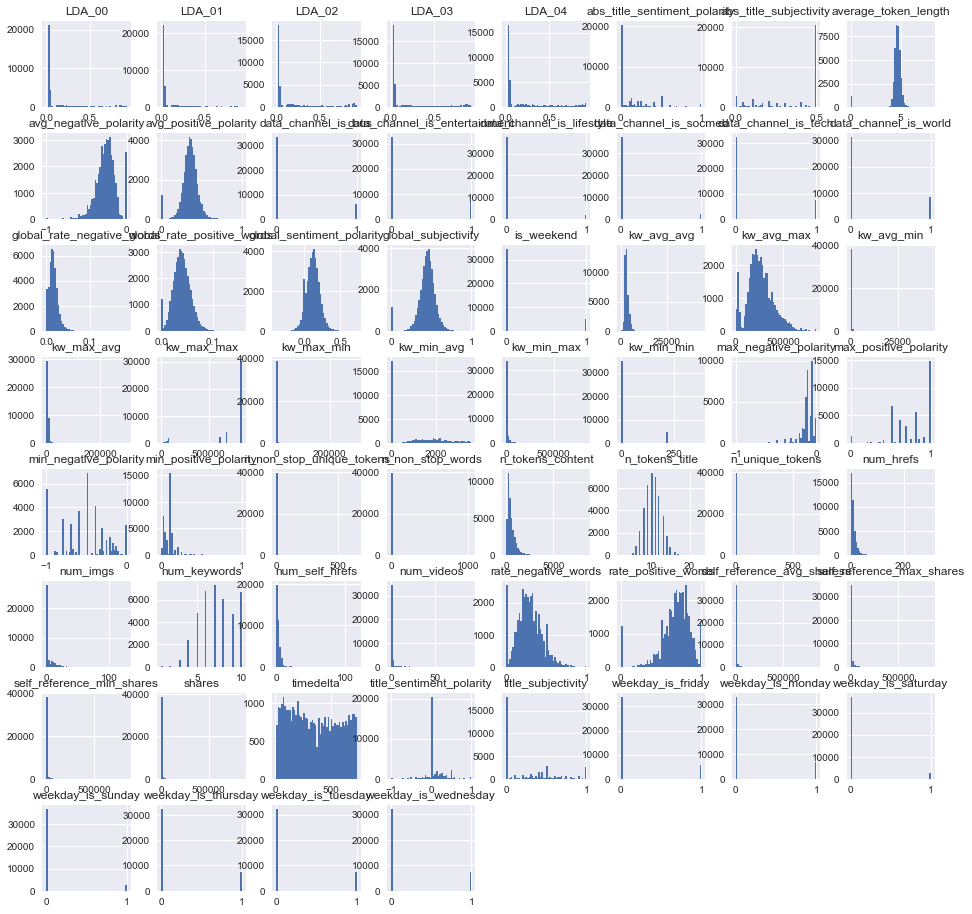

In [7]:
df.hist(bins=50, figsize= (16,16))
plt.show

## 2. Fixing outliers<a name="fixingoutliers"></a>

### Spotting and removing outliers<a name="subparagraph4"></a>
Plotting the 'shares' label in a histogram makes it clear that outliers are present! Anything beyond c.30000 shares is not even visible! Let's remove them before moving further

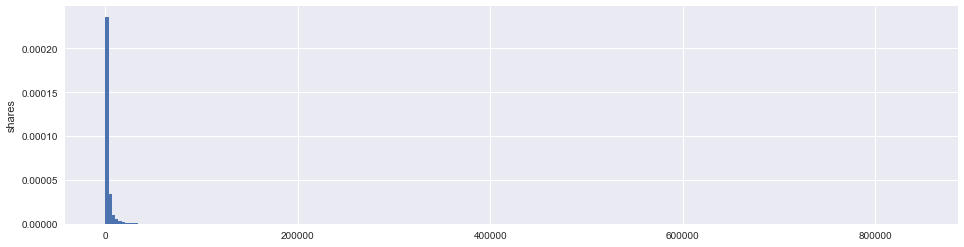

In [10]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] =16.0
fig_size[1] = 4.0
#plt.rcParams["figure.figsize"] = fig_size

x = df['shares']
plt.hist(x, normed=True, bins=250)
plt.ylabel('shares');

We remove the outliers using a function, which leaves out the 'shares' where the value is larger than its mean +/- two standard deviations.

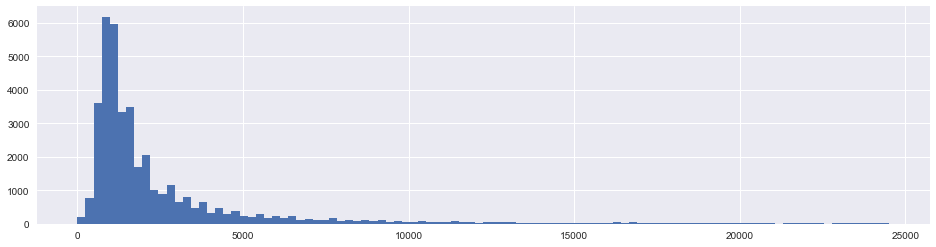

(39053, 1)

In [11]:
def reject_outliers(shares):
    u = np.median(df['shares'])
    s = np.std(df['shares'])
    filtered= [e for e in (df['shares']) if (u - 2 * s < e < u + 2 * s)]
    return filtered

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] =16.0
fig_size[1] = 4.0
#plt.rcParams["figure.figsize"] = fig_size

filtered = reject_outliers('shares')
plt.hist(filtered, 100)
fig_size[0]=16.0
fig_size[1]=8.0
plt.show()

df_shares = pd.DataFrame(filtered)
df_shares.shape


The number of rows in the original dataframe was 39644. Using the function above we spotted and removed 591 outliers altogether, c. 1.5% of the rows.

### Creating a new data set without outliers <a name="subparagraph5"></a>
Let's create a new dataframe - df2 - where outliers are rejected. We define an outlier as a value of 'shares' which is outside two standard deviations (= 3395 + (2 * 11.627) = 26649) of the median for 'shares (3395.38). For this we use Pandas' **Conditional Selection**. <br> 
We obviously consider only the upper bound, which is a positive number. The mean minus two standard deviations would result in a negative number, and it's not possible to have a negative number of 'shares'.<br><br>
Checking the shape of the new dataframe; number of rows and columns.

In [12]:
df2 = df[df['shares']<26647]
df2.shape

(39130, 61)

The new dataframe df2 has c. 500 rows less than the original with the highest value for 'shares' being c. 26650. <br>
There is a slight difference in how many outliers the function *def reject_outliers(shares)* above removes (=591) and how many are removed by the Conditional Selection (=514). This is probably due to rounding errors in the calculation of the mean and standard deviation, since 'shares' above 1000 are rounded to the nearest hundred. 

## 3. Correlations in data - numerically and graphically<a name="correlations"></a>

Next a look at the variables' correlations, numerically and graphically.

In [13]:
corrmat = df2.corr()
corrmat['shares'].sort_values(ascending=False)

shares                           1.000000
kw_avg_avg                       0.184027
LDA_03                           0.122997
kw_max_avg                       0.096294
kw_min_avg                       0.081258
num_hrefs                        0.076651
num_imgs                         0.073403
self_reference_avg_sharess       0.067889
is_weekend                       0.067792
self_reference_min_shares        0.060230
self_reference_max_shares        0.055830
kw_avg_max                       0.052563
global_subjectivity              0.052508
abs_title_sentiment_polarity     0.052128
weekday_is_sunday                0.049506
title_subjectivity               0.048917
data_channel_is_socmed           0.047302
num_keywords                     0.044302
weekday_is_saturday              0.042820
title_sentiment_polarity         0.037470
num_videos                       0.036995
kw_avg_min                       0.036717
kw_max_min                       0.033022
data_channel_is_lifestyle        0

Correlations between the variables and the label 'shares' are throughout rather low. This is presented also by the very light colours in the the matrix below.

### Correlation matrix<a name="subparagraph6"></a>

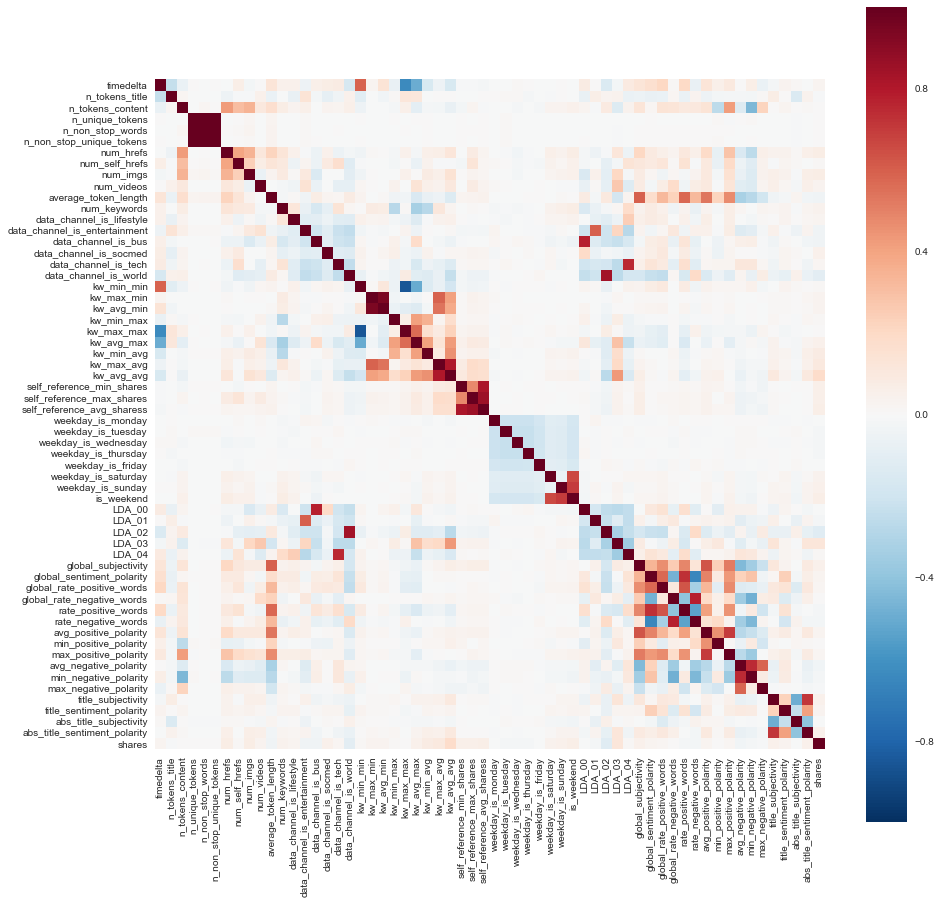

In [14]:
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corrmat, vmax=1, square=True);
plt.show()

the Top 15 of most correlated features' and their types:
- kw_avg_avg - NUMERICAL
- LDA_03 - NUMERICAL
- kw_max_avg - NUMERICAL
- kw_min_avg - NUMERICAL
- num_hrefs - NUMERICAL
- num_imgs - NUMERICAL
- self_reference_avg_sharess - NUMERICAL
- is_weekend - CATEGORICAL
- self_reference_min_shares - NUMERICAL
- self_reference_max_shares - NUMERICAL
- kw_avg_max - NUMERICAL
- global_subjectivity - NUMERICAL
- abs_title_sentiment_polarity - CATEGORICAL
- weekday_is_sunday - CATEGORICAL
- title_subjectivity - CATEGORICAL

Let's view them in  scatter matrices, in three separate ones for clarity's sake.

### Scatter matrices - 15 most correlated features<a name="subparagraph7"></a>

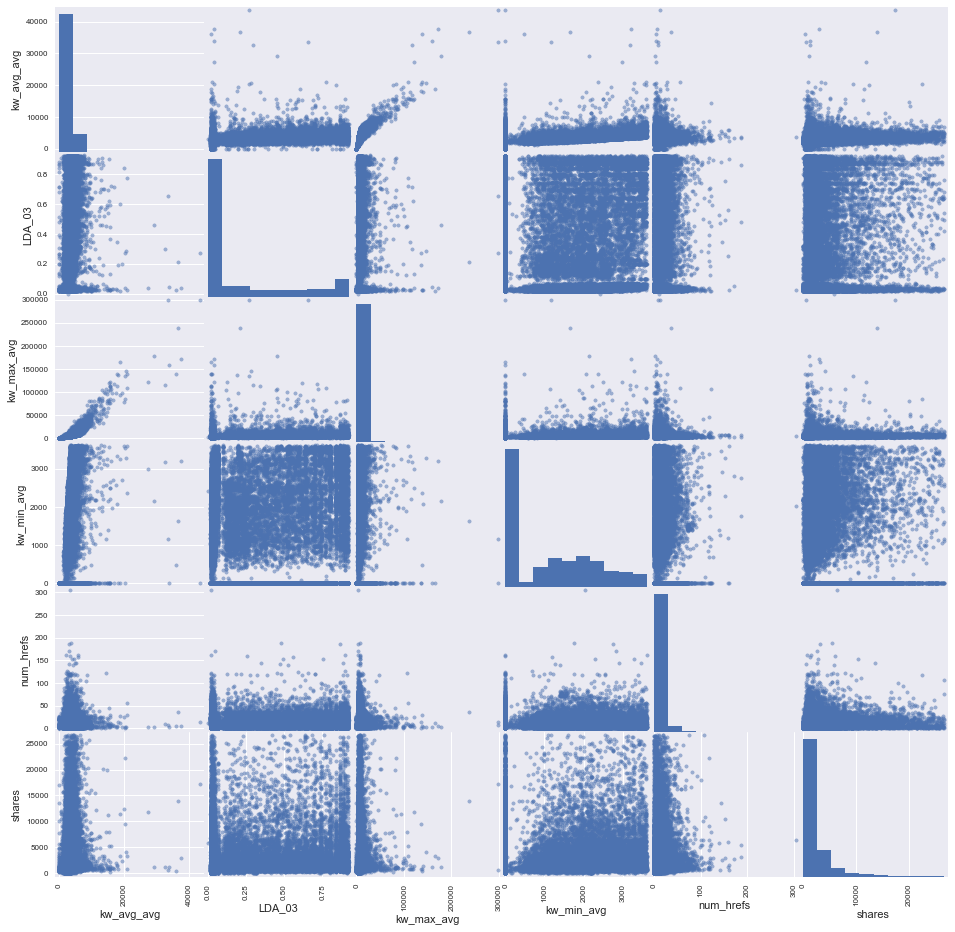

In [15]:
attributes = ['kw_avg_avg','LDA_03','kw_max_avg','kw_min_avg','num_hrefs',"shares"]
scatter_matrix(df2[attributes], figsize=(16, 16));  

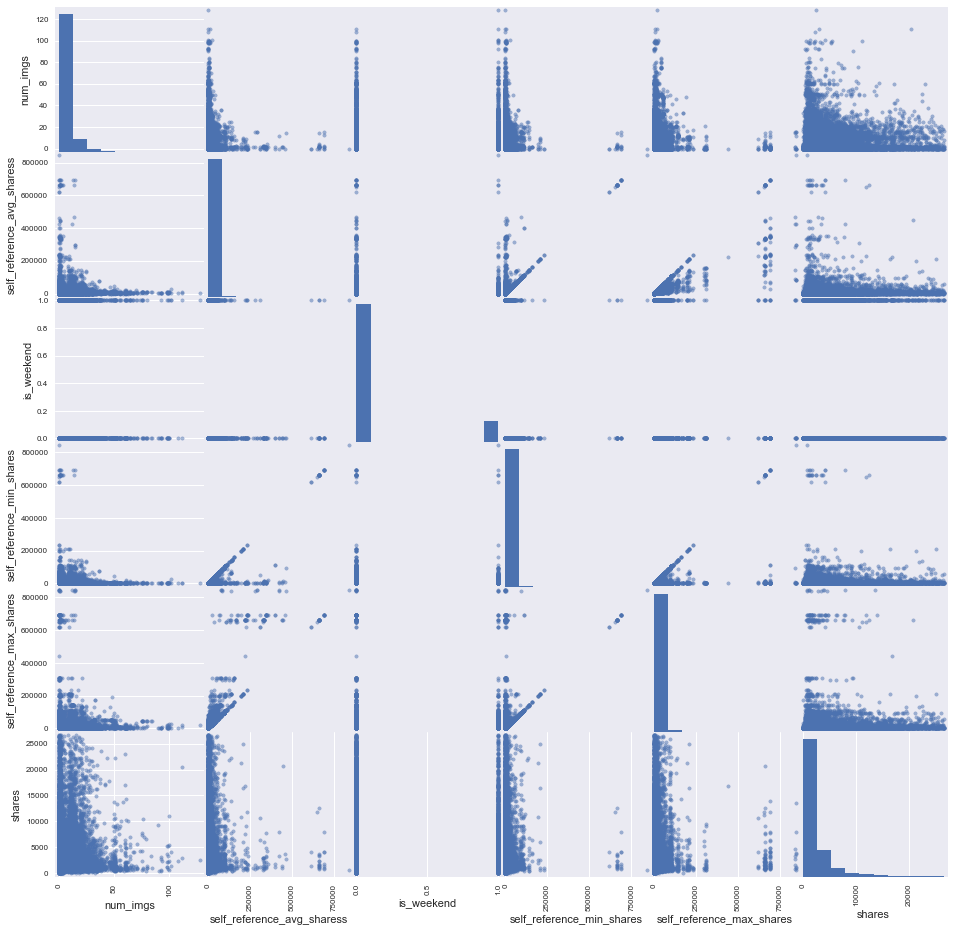

In [16]:
attributes = ['num_imgs','self_reference_avg_sharess','is_weekend','self_reference_min_shares','self_reference_max_shares',"shares"]
scatter_matrix(df2[attributes], figsize=(16, 16));

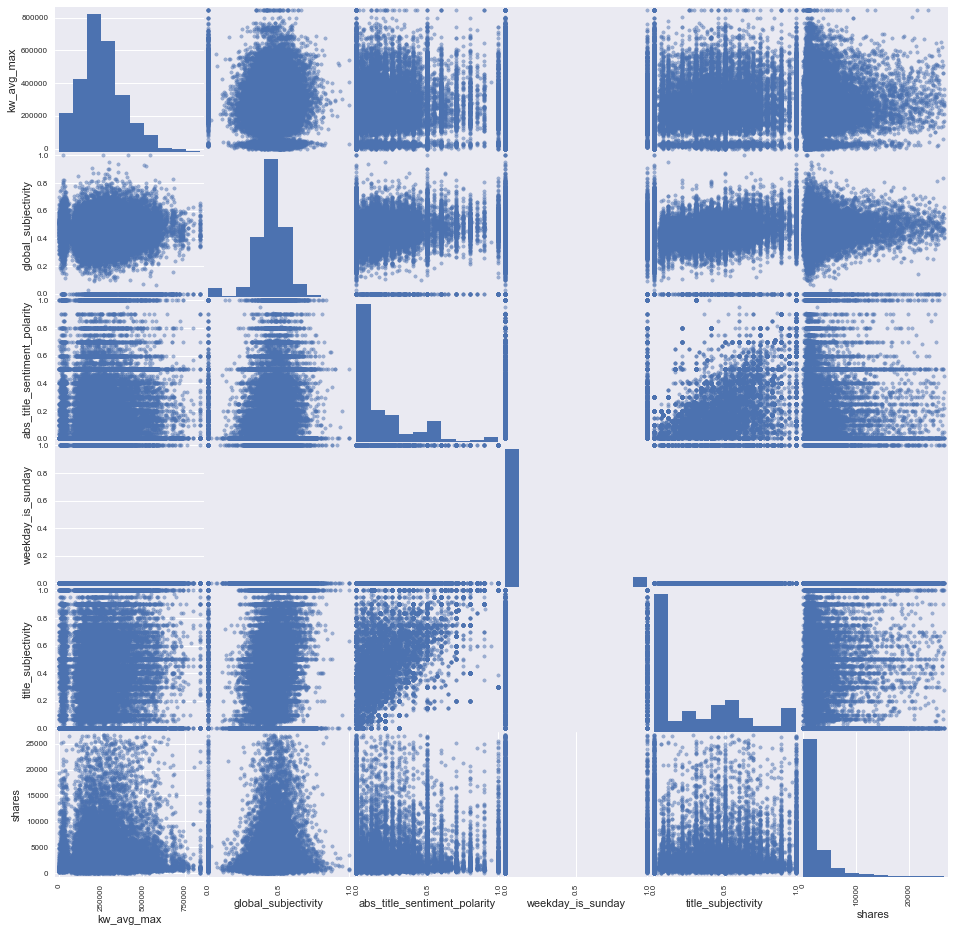

In [17]:
attributes = ['kw_avg_max','global_subjectivity','abs_title_sentiment_polarity','weekday_is_sunday','title_subjectivity',"shares"]
scatter_matrix(df2[attributes], figsize=(16,16));

## 4. Need for Stratified Sampling?<a name="stratsamp"></a>
We have now looked at the data both numerically in a correlation matrix and visually in scatter matrices. It's apparent that no single attribute is clearly more important than the others. The attribute 'kw_avg_avg' has the highest correlation with 'shares', and it's still only barely 0.18. This would mean *stratified sampling*,  dividing the data into into homogenous subgroups called *strata* is not really needed. Even with purely random sampling, the risk for a skewed test set is considered insiginificant.   

## 5. Train Test split <a name="traintest"></a>
Now we need to split our data to a train set (80%) and test set (20%).  The variable we're trying to predict is **'shares**; what determines the probability that a reader will share an online news article. <br>
The **random_state** of the split is set to a fixed number, here the commonly used '42', thereby keeping the random number generator constant. This way we avoid the risk of introducing sampling bias by always getting the same split.

In [18]:
train_set, test_set = train_test_split(df2, test_size=0.20, random_state=42)

X_train_set = train_set.drop(['url','shares'], axis=1) #Dropping both 'shares', the predicted variable and 'url', a text variable
y_train_set = train_set['shares']

X_test_set = test_set.drop(['url','shares'], axis=1)
y_test_set = test_set['shares']

We now have a 80% Train set with 31304 rows and 20% Test set with  7826 rows!!!<br>
Let's introduce the Linear Regression model and try it out with a few instances from the training set.

## 6. Linear Regression<a name="linreg"></a>

In [19]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_set, y_train_set)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [20]:
some_X_data = X_train_set.iloc[:5]
some_y_data = y_train_set.iloc[:5]
print("Predicted shares:", lin_reg.predict(some_X_data))
print("Actual shares:", list(some_y_data))

Predicted shares: [ 2242.96859072  1815.356175    2756.11213385  1944.87264173  1767.35046833]
Actual shares: [1600, 1100, 904, 2500, 981]


We now have a working Linear Regression model! The predictions based on this small sample are still way off. Let's measure the model's RMSE on the whole Training set.

### Linear Regression -  RMSE and MAE for the Training set <a name="subparagraph8"></a>

In [21]:
share_predictions = lin_reg.predict(X_train_set)
lin_mse = mean_squared_error(y_train_set, share_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse #with outliers: 11648.966

3272.5211886365691

In [22]:
df['shares'].median() #with outliers: 1400

1400.0

The median is 1400.  The model with its RMSE around 3300 is clearly *underfitting* the training data. This can mean that the features do not provide enough information to make good predictions, or that the model is not powerful enough.<BR>
The main ways to fix the model in this case are to 
- select a more powerful model
- feed the training algorithm with better features<br><br>
Let's check also the Mean Absolute Error - MAE

In [23]:
lin_mae = mean_absolute_error(y_train_set, share_predictions)
print(lin_mae) #with outliers:3084.94

1902.58061813


## 7. Decision Tree<a name="dt"></a>
Next up; a DT model

In [24]:
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train_set, y_train_set)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=42,
           splitter='best')

In [25]:
some_X_data = X_train_set.iloc[:5]
some_y_data = y_train_set.iloc[:5]
print("Predicted shares:", tree_reg.predict(some_X_data))
print("Actual shares:", list(some_y_data))

Predicted shares: [ 1600.  1100.   904.  2500.   981.]
Actual shares: [1600, 1100, 904, 2500, 981]


And now we have a Decision Tree model! The predictions based on this small sample have zero errors so clearly there something fishy here. Let's investigate further.

### Decision Tree - RMSE and MAE for the Training Set<a name="subparagraph9"></a>

In [26]:
share_predictions = tree_reg.predict(X_train_set)
tree_mse = mean_squared_error(y_train_set, share_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse #with outliers:0.0

0.0

In [27]:
tree_mae = mean_absolute_error(y_train_set, share_predictions)
print(tree_mae)

0.0


No error at all; RMSE and MAE equal zero!! The results seem to indicate we have a perfect model! The likely explanation, though, is that the model had badly overfit the data. <br><br>We could always use the test data to train the model, but we don't want to touch the test data until we have a model we're confident with. So, we're going to use part of the training set for training and part for model validation.<br>


### Cross Validation - Decision Tree<a name="subparagraph10"></a>
A rather easy way to train the model - and getting rid of overfitting - is to use scikit-learn's *K-fold cross-validation*. It randomly splits the training set into *n* distinct subsets, i.e. folds, then trains the model, e.g. a Decision Tree or Random Forest *n* times picking a different fold every time and training on the other *n-1* folds. We use here n=10. 

In [28]:
scores = cross_val_score(tree_reg, X_train_set, y_train_set,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [29]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores) 

Scores: [ 4894.09266257  4822.31051264  4844.32207441  5007.26557426  4944.15862365
  4791.04015623  4953.62486565  4759.64698163  4908.26996486  4728.3966012 ]
Mean: 4865.31280171
Standard deviation: 86.3466368922


Now RMSE for a Decision Tree's predictions do not look that good anymore.

### Cross Validation - Linear Regression<a name="subparagraph11"></a>
Let's compute the same scores for the **Linear Regression** model as well, just to be sure:

In [30]:
lin_scores = cross_val_score(lin_reg, X_train_set, y_train_set,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores) #with outliers:mean 13185 std 7605

Scores: [  3286.57785313   3316.72164929   3300.74938146   3391.38238018
   3355.56724501   3216.19285701  26987.97869435   3224.06329472
   3220.74112548   2975.2340643 ]
Mean: 5627.52085449
Standard deviation: 7120.97777719


After Cross Validation also Linear Regression looks worse. The Decision Tree model still clearly beats the Linear Regression especially based on the Standard Deviation, although only 10 distinct subsets (cv=10) were used.<br>
Let's try next a Random Forest model.

## 8. Random Forest<a name="rf"></a>
Looking for an even better model using Random Forest.

In [31]:
forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(X_train_set, y_train_set)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [32]:
some_X_data = X_train_set.iloc[:5]
some_y_data = y_train_set.iloc[:5]
print("Predicted shares:", forest_reg.predict(some_X_data))
print("Actual shares:", list(some_y_data))

Predicted shares: [ 1383.5  1750.    822.8  2370.   1138.6]
Actual shares: [1600, 1100, 904, 2500, 981]


And now we have a Random Forest model! Its predictions based on this, again very small sample, look actually quite promising. Let's have a closer look.

### Random Forest - RMSE and MAE for the Training Set<a name="subparagraph12"></a>

In [33]:
share_predictions = forest_reg.predict(X_train_set)
forest_mse = mean_squared_error(y_train_set, share_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse #with outliers:5282.35

1495.2627219739318

And next checking the MAE

In [34]:
forest_mae = mean_absolute_error(y_train_set, share_predictions)
print(forest_mae) #with outliers:1424

835.192020189


The results from the Random Forest look so far the most promising.

## 9. Fine-tuning the Random Forest model<a name="finetuning"></a>
### Cross Validation - Random Forest<a name="subparagraph13"></a>

In [35]:
scores = cross_val_score(forest_reg, X_train_set, y_train_set,
                         scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)

In [36]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(forest_rmse_scores) 

Scores: [ 3572.13207731  3493.28860994  3545.70307096  3595.83861748  3493.55652789
  3394.01417997  3753.03307418  3445.82818552  3459.54213355  3185.53113186]
Mean: 3493.84676087
Standard deviation: 139.608599159


Also for Random Forest the results after Cross Validation are gettin worse. 

## 10. Summarizing RMSE and MAE for the three models - pre-Cross Validation<a name="summarize"></a>
The results are<br><br>
**Linear regression**  RMSE : 3272 , MAE : 1902
<br><br>
**Decision Tree** RMSE : 0, MAE : 0
<br><br>
**Random Forest** RMSE : 1495, MAE : 835

Out of these three models the Random Forest performs best, considering that the Decision Tree's RMSE and MAE scores are due to overfitting!

## 11. Hyperparameters and Feature Importance<a name="hyper"></a>

### Finding the optimal number of hyperparameters through Grid Search <a name="subparagraph14"></a>
Since Random Forest was the most promising model we start fine-tuning it. We can use Grid Search instead of fiddling with hyperparameters manually

In [37]:
param_grid = [
     {'n_estimators': [3,10], 'max_features':[2,3,4]},
    {'bootstrap': [False], 'n_estimators': [3,10],'max_features': [2,3,4]}
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring="neg_mean_squared_error")

grid_search.fit(X_train_set, y_train_set)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10], 'max_features': [2, 3, 4]}, {'n_estimators': [3, 10], 'bootstrap': [False], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [38]:
cvres=grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

3823.98688029 {'n_estimators': 3, 'max_features': 2}
3422.04465476 {'n_estimators': 10, 'max_features': 2}
3831.82386692 {'n_estimators': 3, 'max_features': 3}
3421.51852883 {'n_estimators': 10, 'max_features': 3}
3797.26779076 {'n_estimators': 3, 'max_features': 4}
3440.43762724 {'n_estimators': 10, 'max_features': 4}
3799.10273756 {'n_estimators': 3, 'bootstrap': False, 'max_features': 2}
3431.06656283 {'n_estimators': 10, 'bootstrap': False, 'max_features': 2}
3828.64431388 {'n_estimators': 3, 'bootstrap': False, 'max_features': 3}
3438.07796156 {'n_estimators': 10, 'bootstrap': False, 'max_features': 3}
3835.09612789 {'n_estimators': 3, 'bootstrap': False, 'max_features': 4}
3444.0279528 {'n_estimators': 10, 'bootstrap': False, 'max_features': 4}


In [39]:
print(grid_search.best_params_)

{'n_estimators': 10, 'max_features': 3}


Through Grid Search we would get the optimal model with
- max_features = 2, which here determines the maximum number of features to consider while looking for a split
- n_estimators = 10, which here is the number of trees to be used in the forest 
<br><br>


### Finding the optimal number of hyperparameters through Randomized Search <a name="subparagraph15"></a>
The Grid Search is fine when we have only relatively few combinations. But when the hyperparameter *search space* is large, like in our case now, the RandomizedSearchCV is preferable. Instead of trying out all possible combinations, it evaluates a given number of random combinations by selecting a random value for each hyperparameter at every iteration.<br><br>
The limits for the *n_estimators* and *max_features* are set to 20 and 8, respectively, to keep things from getting too complicated.

In [40]:
param_distribs = {
        'n_estimators': randint(low=1, high=20),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(X_train_set, y_train_set)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000275F42DE438>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000275F40D9518>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='neg_mean_squared_error',
          verbose=0)

In [41]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

3381.51260241 {'n_estimators': 15, 'max_features': 7}
3484.42365301 {'n_estimators': 8, 'max_features': 3}
3526.60639958 {'n_estimators': 7, 'max_features': 5}
3340.34987831 {'n_estimators': 19, 'max_features': 2}
3421.38731421 {'n_estimators': 11, 'max_features': 7}
3699.1999653 {'n_estimators': 4, 'max_features': 3}
4085.12367724 {'n_estimators': 2, 'max_features': 3}
3570.26293228 {'n_estimators': 6, 'max_features': 4}
4694.29786189 {'n_estimators': 1, 'max_features': 2}
3418.1038899 {'n_estimators': 12, 'max_features': 4}


We seem to obtain the best solution - i.e. with lowest RMSE - by setting *max_features* hyperparameter to 2 and the *n_estimators* hyperparameter to 19; RMSE:3340.35<br><br>
For the chosen model, Random Forest, we can use the *RandomForestRegressor* to find the relative importance of each attribute for making accurate predictions.<br>

In [42]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([ 0.02685134,  0.01760526,  0.02713588,  0.02367648,  0.00041435,
        0.02523471,  0.02386276,  0.01392021,  0.01979341,  0.01200219,
        0.02395041,  0.01254874,  0.00289328,  0.00365326,  0.0026654 ,
        0.00261018,  0.00343672,  0.0027455 ,  0.00614577,  0.02510442,
        0.02804941,  0.01677698,  0.00524989,  0.02748242,  0.02026202,
        0.03570348,  0.03986575,  0.02945843,  0.02392435,  0.030722  ,
        0.00388505,  0.00391485,  0.00403145,  0.00364704,  0.00356801,
        0.00238776,  0.00305293,  0.00418092,  0.02829361,  0.02797842,
        0.02621283,  0.02674201,  0.02573894,  0.02675165,  0.02333073,
        0.02282777,  0.02206081,  0.02033655,  0.01944138,  0.02476763,
        0.01361017,  0.01210906,  0.02415892,  0.01550094,  0.01458223,
        0.01514913,  0.01780366,  0.0135889 ,  0.01660166])

Since Feature Importances are normalized they sum to one and describe how much a single feature contributes to the forest's total impurity reduction. To be noted is that if some features in the data are correlated they will get a lower importance than an equally important uncorrelated feature. Therefore, before just starting to remove features with low importance one should check for possible high correlations first.

### Feature Importances - numerically and graphically<a name="subparagraph16"></a>
Let's view the Feature Importance scores next to their corresponding attribute names:

In [44]:
attributes_all = ['kw_avg_avg','LDA_03','kw_max_avg','kw_min_avg','num_hrefs','num_imgs','self_reference_avg_sharess','is_weekend','self_reference_min_shares','self_reference_max_shares','kw_avg_max','global_subjectivity','abs_title_sentiment_polarity','weekday_is_sunday','title_subjectivity','data_channel_is_socmed','num_keywords','weekday_is_saturday','title_sentiment_polarity','num_videos','kw_avg_min','kw_max_min','data_channel_is_lifestyle','avg_positive_polarity','timedelta','global_sentiment_polarity','max_positive_polarity','data_channel_is_tech','global_rate_positive_words','kw_min_max','num_self_hrefs','LDA_04','kw_min_min','kw_max_max','global_rate_negative_words','n_tokens_content','n_unique_tokens','n_non_stop_words','n_non_stop_unique_tokens','min_positive_polarity','abs_title_subjectivity','weekday_is_friday','weekday_is_monday','LDA_00','max_negative_polarity','n_tokens_title','weekday_is_thursday','rate_positive_words','weekday_is_tuesday','min_negative_polarity','weekday_is_wednesday','LDA_01','rate_negative_words','avg_negative_polarity','data_channel_is_entertainment','data_channel_is_bus','average_token_length','data_channel_is_world','LDA_02']

In [45]:
sorted(zip(feature_importances, attributes_all), reverse=True)

[(0.039865750022309999, 'max_positive_polarity'),
 (0.035703480076107269, 'global_sentiment_polarity'),
 (0.030722002336236908, 'kw_min_max'),
 (0.029458431053982242, 'data_channel_is_tech'),
 (0.028293610574067839, 'n_non_stop_unique_tokens'),
 (0.028049408494131477, 'kw_avg_min'),
 (0.027978422286094335, 'min_positive_polarity'),
 (0.027482421318538473, 'avg_positive_polarity'),
 (0.027135881403318535, 'kw_max_avg'),
 (0.026851337657026964, 'kw_avg_avg'),
 (0.026751653650026151, 'LDA_00'),
 (0.026742009397014925, 'weekday_is_friday'),
 (0.0262128319604455, 'abs_title_subjectivity'),
 (0.025738942319418416, 'weekday_is_monday'),
 (0.0252347108822998, 'num_imgs'),
 (0.025104416223235719, 'num_videos'),
 (0.024767627161752799, 'min_negative_polarity'),
 (0.024158918859044372, 'rate_negative_words'),
 (0.023950406888606939, 'kw_avg_max'),
 (0.023924351412191569, 'global_rate_positive_words'),
 (0.023862758931438639, 'self_reference_avg_sharess'),
 (0.023676484047972877, 'kw_min_avg'),
 (

And create a separate, sorted dataframe for them.

In [46]:
df_nn = pd.DataFrame(feature_importances, attributes_all)
df_nn.reset_index(level=0, inplace=True)
df_nn.sort_values(0).rename(index=str, columns={"index": "Feature", 0: "importance"})

,Feature,importance
4,num_hrefs,0.000414
35,n_tokens_content,0.002388
15,data_channel_is_socmed,0.002610
14,title_subjectivity,0.002665
17,weekday_is_saturday,0.002745
12,abs_title_sentiment_polarity,0.002893
36,n_unique_tokens,0.003053
16,num_keywords,0.003437
34,global_rate_negative_words,0.003568
33,kw_max_max,0.003647


Next, viewing the outcome graphically.

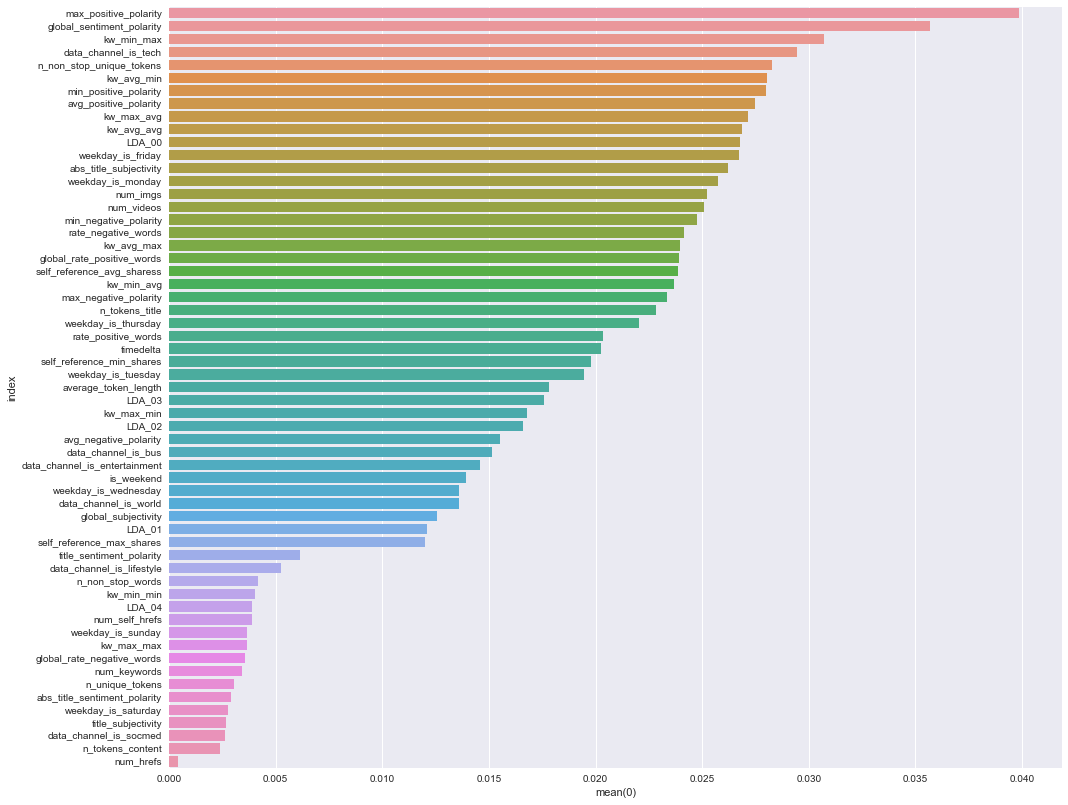

In [47]:
f, ax = plt.subplots(figsize=(16, 14))
sns.set_color_codes("pastel")
ax = sns.barplot( y='index', x= 0, data=df_nn.sort_values([0], ascending=[False]))

## 12. Evaluating the Final Model with the Test Set<a name="evaluate"></a>
Finally, using the test set we've kept aside, let's check how good the model is.

In [48]:
final_model = grid_search.best_estimator_

final_predictions = final_model.predict(X_test_set)

final_mse = mean_squared_error(y_test_set, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

3246.8837293325182

And RMSE of 3212.04, which is somewhat lower than the 3340.3 we got with Randomized Search Cross Validation above. So, at least it didn't get worse.

Next, testing the model with actual data

In [49]:

some_X_data = X_test_set.iloc[:] #seems to be working also w-o .iloc!
some_y_data = y_test_set.iloc[:] #seems to be working also w-o .iloc!
Predicted_shares = list(final_model.predict(some_X_data)) #added list() 7.2. !!!!!
Actual_shares = list(some_y_data)
final_data = [Predicted_shares, Actual_shares]
#final_data = [final_model.predict(some_X_data), list(some_y_data)]
#final_data
#print(Actual_shares)
#print(Predicted_shares)
#NOTE!!! 'FINAL DATA IS AN ARRAY OF TWO LISTS; Actual shares and Predicted shares!!!! 



The 'final_data' consist now of the Predicted values for 'shares' the model creates, and the Actual values for 'shares' from our test set we've kept aside for this. In order to view it graphically, we create the needed dataframes. First, we sort the data.

In [50]:
sorted(zip(Predicted_shares, Actual_shares), reverse=True);

And then looking at the values side by side.

In [51]:
df_shares = pd.DataFrame(Predicted_shares, Actual_shares)   
df_shares.reset_index(level=0, inplace=True)
df_shares_AvsP = df_shares.rename(index=str, columns={"index": "Actual shares", 0: "Predicted shares"})

This is what the result looks like plotting the Predicted shares against Actual shares.

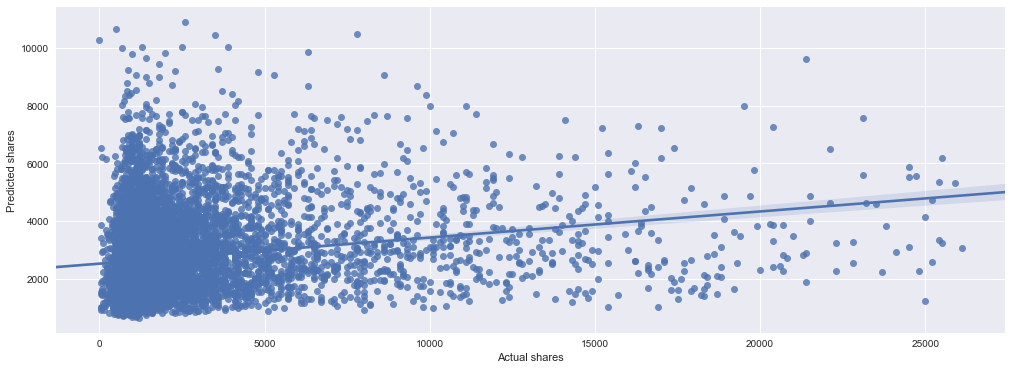

In [52]:
f, ax = plt.subplots(figsize=(17, 6))
sns.regplot(x=df_shares_AvsP["Actual shares"], y=df_shares_AvsP["Predicted shares"])
sns.plt.show()

The results don't look too encouraging! There is a lot of  dispersion. Plotting them in a histogram gives a different perspective, but still shows Predictions from the model tend to be more evenly distributed with a lower kurtosis.

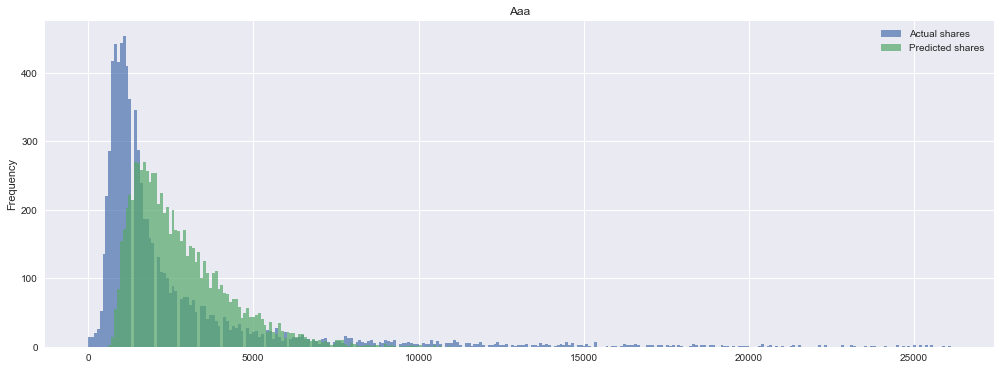

In [53]:
fig_size[0]=17.0
fig_size[1]=6.0

df_shares_AvsP.plot(bins=300, kind='hist', alpha=0.7)
plt.title('Aaa')
axes=plt.axes()
plt.show()

The outcome is further confirmed by the very low R2 score:

In [54]:
from sklearn.metrics import r2_score

r2_score( Actual_shares, Predicted_shares)

-0.032210467389361064

The model's prediction power is basically zero!

## 13. Conlusions<a name="conclusions"></a>

Clearly, there is room for improvement here, if we continue using a Random Forest model.<br><br>
Next steps could be to simplify the model by reducing the number of features to say 20-30 by removing less important ones.<br><br> 
Another one would be getting rid of outliers even further. Now outliers were defined as the number of 'shares' with  +/- 2 standard deviations bigger than its mean. In practice observations where number of 'shares' was above 26647 were left out, which counted for only 1.5% of the data. <br><br>
To be continued.